# Install libraries

In [1]:
%pip install --upgrade pip
%pip install matplotlib
%pip install pandas
%pip install py4j
%pip install scipy

#%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Handle Java Virtual Machines

## Import libraries to run/terminate JVM

In [3]:
from contextlib import closing
import os
import sys
import platform
import socket
import subprocess
from subprocess import PIPE
import tempfile
import pandas as pd
import time

import matplotlib.pyplot as plt

#import seaborn as sns
#sns.set_theme()

import numpy as np


from py4j.java_gateway import JavaGateway, GatewayParameters
from py4j.java_collections import ListConverter

import scipy

from datetime import datetime

# Download the latest version of the ERODE library

In [3]:
import urllib.request
from pathlib import Path

base_url="https://www.erode.eu/distr/erode_python/"
files=["erode.jar","AM.ode","kaic.ode","MI.ode","test2.csv","test2B.csv"]

for file in files:
  url=base_url+file
  urllib.request.urlretrieve(url,Path(url).name)

## Define functions to run/terminate JVM

In [4]:
class ErodeHandler:
    ## Specify path to java JDK
    #Default string. Can be changed using the constructor of erodeHandler
    #__JAVA_PATH__="/Library/Java/JavaVirtualMachines/jdk-11.0.14.jdk/Contents/Home/bin/java"
    #__JAVA_PATH__="/usr/lib/jvm/java-8-openjdk-amd64/Contents/Home/bin/java"
    __JAVA_PATH__="java"
    __IN_COLAB__ = False #'google.colab' in sys.modules

    ## Specify path to java JDK
    #Default string. 
    __ERODE_JAR__ = "erode.jar" #os.path.join(os.path.dirname(__file__), "erode.jar")

    ## Specify whether a new JVM shall be created, or whether we shall connect to an existing one
    # Do not change
    __STARTJVM__ = True
    
    def __init__(self,j_path=__JAVA_PATH__):
        self._java_path=j_path
        self.erode_jar=ErodeHandler.__ERODE_JAR__
        if ErodeHandler.__IN_COLAB__:
          print('I install java')
          self._install_java()

    def _install_java(self):
      !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
      os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
      #!java -version       #check java version
      ErodeHandler.__JAVA_PATH__="java"
      

    def _start_server(self):
        # find a free port
        for port in range(25333, 65545):
            with closing(socket.socket(socket.AF_INET, socket.SOCK_STREAM)) as s:
                dest_addr = ("127.0.0.1", port)
                if s.connect_ex(dest_addr):
                    break

        #ld_path = __ERODE_LIB_DIR__
        ld_path='native/osx'
        #java="java"
        java =self._java_path
        argv = [java, f'-Djava.library.path="{ld_path}"',
                    "-jar", self.erode_jar, str(port)]
        #print("argv",argv)
        if platform.system() == "Linux":
            env_ld_path = os.getenv("LD_LIBRARY_PATH")
            if env_ld_path:
                ld_path = f"{ld_path}:{env_ld_path}"
            env ={"LD_LIBRARY_PATH": ld_path}
            proc = subprocess.Popen(" ".join(argv), stdout=PIPE,
                    shell=True, env=env)
        else:
            proc = subprocess.Popen(argv, stdout=PIPE)
        proc.stdout.readline()

        self._proc=proc
        self._port=port

        time.sleep(1) # Sleep for 1 second
        return #proc, port

    def _stop_server(self):
        if ErodeHandler.__STARTJVM__:
            print('Terminating JVM and ERODE')
            time.sleep(1) # Sleep for 1 second
            self._proc.terminate()
            try:
                self._proc.wait(5)
            except subprocess.TimeoutExpired:
                self._proc.kill()
                self._proc.wait()
            print(' Completed')
        else:
            print('Nothing to terminate')

    def start_JVM(self):
        print('Starting the JVM and ERODE')
        if ErodeHandler.__STARTJVM__:
            #self._proc, self._port = _start_server()
            self._start_server()
        else:
            self._proc =-1
            self._port =25347
        gw_params = GatewayParameters(port=self._port)#, auto_convert=True)
        self._gw = JavaGateway(gateway_parameters=gw_params)

        self.int_class   =self._gw.jvm.int    # make int class
        self.double_class=self._gw.jvm.double # make double class
        self.erode = self._gw.entry_point
        #print(_proc)
        #_port
        print('  Completed')
        return self.erode #,self._proc,self._port
            
    def j_to_py_matrix(self,metrics_java):
        metrics_python= [ list(line) for line in metrics_java ]
        return metrics_python        

    def j_to_py_list(self,partition_java):
        partition_python= [ int(entry) for entry in partition_java ]
        return partition_python


    #Takes in input a list of int created in python. Gives in output a corresponding array of int for java
    def py_to_j_list(self,python_int_list):
        java_int_array = self._gw.new_array(self.int_class,len(python_int_list))
        #double_array = gateway.new_array(self.double_class,1,len(partition_python))

        for i in range(len(python_int_list)):
            java_int_array[i]=python_int_list[i]
        
        return java_int_array

    def matrix_to_upper_diagonal(m):
        l=[]
        for i in range(len(m)):
            for j in range(i+1,len(m)):
                l.append(m[i][j])
        return l

# Use ERODE

## Start ERODE and VM

In [5]:
#Always start ERODE on a JVM
erodeHandler = ErodeHandler()
erode=erodeHandler.start_JVM()
type(erode)

Starting the JVM and ERODE
  Completed


py4j.java_gateway.JavaObject

## Tests

### Import Affine systems

In [6]:
erode.importAffine("test2.csv","test2B.csv")
nVars=erode.getVariablesNum()
print('The loaded model has',nVars,'variables')
print(erode.getModelString())

The loaded model has 3 variables
test2.csv: 2 reactions, 3 species.
Species:
[S0, S1, S2]
 Reactions:
[S1-- (1.0) -->S0+S1, S2-- (1.0) -->S0+S2]


### Import and reduce ODEs

In [7]:
erode.loadModel("AM.ode")
print('We have loaded model',erode.getModelName())
print(erode.getModelString())

We have loaded model AM.ode
AM.ode: 4 reactions, 3 species.
Species:
[x0, x1, x2]
 Reactions:
[x0+x2-- (p1) -->x1+x2, x0+x2-- (p2) -->x0+x1, x0+x1-- (p3) -->2*x0, x1+x2-- (p4) -->2*x2]


In [8]:
obtained = erode.computeBE();
print()
print(type(obtained))
print()
print(erode.getPartitionString(obtained))


<class 'py4j.java_collections.JavaArray'>

The partition has 1 block out of 3 species:
Block 1, Size: 3
0-x0 
1-x1 
2-x2 



In [9]:
n_blocks=erode.getNumberOfBlocks(obtained)
print("The partition has",n_blocks,"blocks")

The partition has 1 blocks


#### We can provide custom prepartitions
- E.g., we don't want to mix x2 with the other two variables
- We just need to make a pre-pratitiong of the viariables: {{x0,x1},{x2}} 
- We do this by creating a list of int with one entry per variable. 
- The int values will denote blocks of the pre-partitions: variables with assigned same number will stay together
- E.g, we can encode {{x0,x1},{x2}} as [1,1,2]

In [10]:
pre_part=erodeHandler.py_to_j_list([1,1,2])

print("ERODE will ue the following pre_partition")
print(erode.getPartitionString(pre_part))

n_blocks=erode.getNumberOfBlocks(pre_part)
print("The initial partition has",n_blocks,"blocks\n")

obtained_prep = erode.computeBE(pre_part);
#obtained_prep
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))

ERODE will ue the following pre_partition
The partition has 2 blocks out of 3 species:
Block 1, Size: 2
0-x0 
1-x1 

Block 2, Size: 1
2-x2 

The initial partition has 2 blocks

This is the obtained partition
The partition has 3 blocks out of 3 species:
Block 1, Size: 1
0-x0 

Block 2, Size: 1
1-x1 

Block 3, Size: 1
2-x2 



#### We can provide the prepartition written in the model, if any


In [11]:
pre_part=erode.getUserDefinedPartition()

print("ERODE will use the following pre_partition")
print(erode.getPartitionString(pre_part))

obtained_prep = erode.computeBE(pre_part);
#obtained_prep
print("This is the obtained partition")
print(erode.getPartitionString(obtained_prep))

ERODE will use the following pre_partition
The partition has 2 blocks out of 3 species:
Block 1, Size: 2
0-x0 
2-x2 

Block 2, Size: 1
1-x1 

This is the obtained partition
The partition has 2 blocks out of 3 species:
Block 1, Size: 2
0-x0 
2-x2 

Block 2, Size: 1
1-x1 



#### Further examples of reduction

In [12]:
obtained = erode.computeFE();
obtained
print(erode.getPartitionString(obtained))

The partition has 1 block out of 3 species:
Block 1, Size: 3
0-x0 
1-x1 
2-x2 



In [13]:
erode.loadModel("MI.ode")
print('We have loaded model',erode.getModelName())
print(erode.getModelString())
obtained = erode.computeBE();

print()
print("BE reduction of MI")
print(erode.getPartitionString(obtained))

We have loaded model MI.ode
MI.ode: 8 reactions, 6 species.
Species:
[Y0, Z0, Y1, Z1, Y2, Z2]
 Reactions:
[Y0+Z0-- (k1) -->Z0+Y1, Z0+Y1-- (k2) -->Z0+Y2, Y0+Y2-- (k3) -->Y0+Y1, Y0+Y1-- (k4) -->2*Y0, Z0+Z2-- (k1) -->Z0+Z1, Z0+Z1-- (k2) -->2*Z0, Y0+Z0-- (k3) -->Y0+Z1, Y0+Z1-- (k4) -->Y0+Z2]

BE reduction of MI
The partition has 1 block out of 6 species:
Block 1, Size: 6
0-Y0 
1-Z0 
2-Y1 
3-Z1 
4-Y2 
5-Z2 



In [14]:
erode.loadModel("kaic.ode")
print('We have loaded model',erode.getModelName())
print(erode.getModelString())

print()
obtained = erode.computeFE();
print("FE reduction of KAIC")
print(erode.getPartitionString(obtained))

print()
erode.simulateODE(1.0,100,"kaic.csv")

We have loaded model kaic.ode
kaic.ode: 8 reactions, 4 species.
Species:
[OO, PP, OP, PO]
 Reactions:
[OO+PP-- (k1) -->PP+OP, PP+OP-- (k2) -->2*PP, OO+PP-- (k1) -->OO+OP, OO+OP-- (k2) -->2*OO, OO+PP-- (k1) -->PP+PO, PP+PO-- (k2) -->2*PP, OO+PP-- (k1) -->OO+PO, OO+PO-- (k2) -->2*OO]

FE reduction of KAIC
The partition has 2 blocks out of 4 species:
Block 1, Size: 2
0-OO 
1-PP 

Block 2, Size: 2
2-OP 
3-PO 




#### Lists & arrays: From java to python and viceversa

In [15]:
#Convert a python list of int to a java array of int
#  This allows to specify custom initial partitions
array_java=erodeHandler.py_to_j_list([1,1,2])

#Convert a java array of int to a python list of int
#  This allows to use in python a partition computed by ERODE
py_list=erodeHandler.j_to_py_list(array_java)
py_list

[1, 1, 2]

### Simulate ODEs

In [14]:
erode.loadModel("kaic.ode")
print('We have loaded model',erode.getModelName())
print(erode.getModelString())

print()
erode.simulateODE(1.0,100,"kaic.csv")
df_csv=pd.read_csv("kaic.csv.cdat")
df_csv

We have loaded model kaic.ode
kaic.ode: 8 reactions, 4 species.
Species:
[OO, PP, OP, PO]
 Reactions:
[OO+PP-- (k1) -->PP+OP, PP+OP-- (k2) -->2*PP, OO+PP-- (k1) -->OO+OP, OO+OP-- (k2) -->2*OO, OO+PP-- (k1) -->PP+PO, PP+PO-- (k2) -->2*PP, OO+PP-- (k1) -->OO+PO, OO+PO-- (k2) -->2*OO]



,# time,OO,PP,OP,PO,
0,0.000000,2.000000,2.000000,0.000000,0.000000,NaN
1,0.010101,1.961170,1.961170,0.038830,0.038830,NaN
2,0.020202,1.925271,1.925271,0.074729,0.074729,NaN
3,0.030303,1.892010,1.892010,0.107990,0.107990,NaN
4,0.040404,1.861130,1.861130,0.138870,0.138870,NaN
...,...,...,...,...,...,...
95,0.959596,1.342971,1.342971,0.657029,0.657029,NaN
96,0.969697,1.342586,1.342586,0.657414,0.657414,NaN
97,0.979798,1.342218,1.342218,0.657782,0.657782,NaN
98,0.989899,1.341863,1.341863,0.658137,0.658137,NaN


<AxesSubplot:>

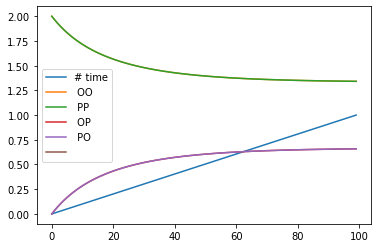

In [15]:
df_csv.plot()

## Terminate ERODE and JVM

In [23]:
#Do not forget to close ERODE and the JVM when you are done
erodeHandler._stop_server()

Terminating JVM and ERODE
 Completed
